In [1]:
import math
import numpy as np
import pandas as pd

from PIL import Image
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torch.nn import init
import torch
from torch.utils import model_zoo
from collections import OrderedDict

In [2]:
pretrained_settings = {
    'se_resnext50_32x4d': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnext101_32x4d': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnext101_32x4d-3b2fe3d8.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
}

# Source: https://github.com/Cadene/pretrained-models.pytorch/blob/master/pretrainedmodels/models/senet.py

class SEModule(nn.Module):

    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1,
                             padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1,
                             padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x
    
    
class Bottleneck(nn.Module):
    """
    Base class for bottlenecks that implements `forward()` method.
    """
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = self.se_module(out) + residual
        out = self.relu(out)

        return out
    
    
class SEBottleneck(Bottleneck):
    """
    Bottleneck for SENet154.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes * 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes * 2)
        self.conv2 = nn.Conv2d(planes * 2, planes * 4, kernel_size=3,
                               stride=stride, padding=1, groups=groups,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes * 4)
        self.conv3 = nn.Conv2d(planes * 4, planes * 4, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNetBottleneck(Bottleneck):
    """
    ResNet bottleneck with a Squeeze-and-Excitation module. It follows Caffe
    implementation and uses `stride=stride` in `conv1` and not in `conv2`
    (the latter is used in the torchvision implementation of ResNet).
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEResNetBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False,
                               stride=stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1,
                               groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNeXtBottleneck(Bottleneck):
    """
    ResNeXt bottleneck type C with a Squeeze-and-Excitation module.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None, base_width=4):
        super(SEResNeXtBottleneck, self).__init__()
        width = math.floor(planes * (base_width / 64)) * groups
        self.conv1 = nn.Conv2d(inplanes, width, kernel_size=1, bias=False,
                               stride=1)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride,
                               padding=1, groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = nn.Conv2d(width, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride
        
        
class SENet(nn.Module):

    def __init__(self, block, layers, groups, reduction, dropout_p=0.2,
                 inplanes=128, input_3x3=True, downsample_kernel_size=3,
                 downsample_padding=1, num_classes=1000):
        """
        Parameters
        ----------
        block (nn.Module): Bottleneck class.
            - For SENet154: SEBottleneck
            - For SE-ResNet models: SEResNetBottleneck
            - For SE-ResNeXt models:  SEResNeXtBottleneck
        layers (list of ints): Number of residual blocks for 4 layers of the
            network (layer1...layer4).
        groups (int): Number of groups for the 3x3 convolution in each
            bottleneck block.
            - For SENet154: 64
            - For SE-ResNet models: 1
            - For SE-ResNeXt models:  32
        reduction (int): Reduction ratio for Squeeze-and-Excitation modules.
            - For all models: 16
        dropout_p (float or None): Drop probability for the Dropout layer.
            If `None` the Dropout layer is not used.
            - For SENet154: 0.2
            - For SE-ResNet models: None
            - For SE-ResNeXt models: None
        inplanes (int):  Number of input channels for layer1.
            - For SENet154: 128
            - For SE-ResNet models: 64
            - For SE-ResNeXt models: 64
        input_3x3 (bool): If `True`, use three 3x3 convolutions instead of
            a single 7x7 convolution in layer0.
            - For SENet154: True
            - For SE-ResNet models: False
            - For SE-ResNeXt models: False
        downsample_kernel_size (int): Kernel size for downsampling convolutions
            in layer2, layer3 and layer4.
            - For SENet154: 3
            - For SE-ResNet models: 1
            - For SE-ResNeXt models: 1
        downsample_padding (int): Padding for downsampling convolutions in
            layer2, layer3 and layer4.
            - For SENet154: 1
            - For SE-ResNet models: 0
            - For SE-ResNeXt models: 0
        num_classes (int): Number of outputs in `last_linear` layer.
            - For all models: 1000
        """
        super(SENet, self).__init__()
        self.inplanes = inplanes
        if input_3x3:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, 64, 3, stride=2, padding=1,
                                    bias=False)),
                ('bn1', nn.BatchNorm2d(64)),
                ('relu1', nn.ReLU(inplace=True)),
                ('conv2', nn.Conv2d(64, 64, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn2', nn.BatchNorm2d(64)),
                ('relu2', nn.ReLU(inplace=True)),
                ('conv3', nn.Conv2d(64, inplanes, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn3', nn.BatchNorm2d(inplanes)),
                ('relu3', nn.ReLU(inplace=True)),
            ]
        else:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, inplanes, kernel_size=7, stride=2,
                                    padding=3, bias=False)),
                ('bn1', nn.BatchNorm2d(inplanes)),
                ('relu1', nn.ReLU(inplace=True)),
            ]
        # To preserve compatibility with Caffe weights `ceil_mode=True`
        # is used instead of `padding=1`.
        layer0_modules.append(('pool', nn.MaxPool2d(3, stride=2,
                                                    ceil_mode=True)))
        self.layer0 = nn.Sequential(OrderedDict(layer0_modules))
        self.layer1 = self._make_layer(
            block,
            planes=64,
            blocks=layers[0],
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=1,
            downsample_padding=0
        )
        self.layer2 = self._make_layer(
            block,
            planes=128,
            blocks=layers[1],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer3 = self._make_layer(
            block,
            planes=256,
            blocks=layers[2],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer4 = self._make_layer(
            block,
            planes=512,
            blocks=layers[3],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.avg_pool = nn.AvgPool2d(7, stride=1)
        self.dropout = nn.Dropout(dropout_p) if dropout_p is not None else None
        self.last_linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, groups, reduction, stride=1,
                    downsample_kernel_size=1, downsample_padding=0):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=downsample_kernel_size, stride=stride,
                          padding=downsample_padding, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, groups, reduction, stride,
                            downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups, reduction))

        return nn.Sequential(*layers)

    def features(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def logits(self, x):
        x = self.avg_pool(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x


def initialize_pretrained_model(model, num_classes, settings):
    assert num_classes == settings['num_classes'], \
        'num_classes should be {}, but is {}'.format(
            settings['num_classes'], num_classes)
    model.load_state_dict(model_zoo.load_url(settings['url']))
    model.input_space = settings['input_space']
    model.input_size = settings['input_size']
    model.input_range = settings['input_range']
    model.mean = settings['mean']
    model.std = settings['std']


def se_resnext50_32x4d(num_classes=1000, pretrained=True):
    model = SENet(SEResNeXtBottleneck, [3, 4, 6, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained:
        settings = pretrained_settings['se_resnext50_32x4d']['imagenet']
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnext101_32x4d(num_classes=1000, pretrained=False):
    model = SENet(SEResNeXtBottleneck, [3, 4, 23, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained:
        settings = pretrained_settings['se_resnext101_32x4d']['imagenet']
        initialize_pretrained_model(model, num_classes, settings)
    return model

In [3]:
def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)


class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)

    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

In [34]:
def GradCam(img, c, feature_fn, classifier_fn):
    feats = feature_fn(img)
    _, N, H, W = feats.size()
    out = classifier_fn(feats)
    c_score = out[0, c]
    grads = torch.autograd.grad(c_score, feats)
    w = grads[0][0].mean(-1).mean(-1)
    sal = torch.matmul(w, feats.view(N, H*W))
    sal = F.relu(sal)
    sal = sal.view(H, W).cpu().detach().numpy()
    sal = np.maximum(sal, 0)
    return sal


class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)

    
def show_gradcam(model, imga_id):
    model.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    img = cv2.imread(f'../data/input/train_images/{img_id}.png')
    img = cv2.resize(img, (256, 256))
    
    features_fn = nn.Sequential(*list(model.children())[:-2])
    classifier_fn = nn.Sequential(*(list(model.children())[-2:-1] + [Flatten()] + list(model.children())[-1:]))
    
    input_data = torch.tensor(img.reshape(1, img.shape[2], img.shape[0], img.shape[1])).to(device).float()
    pp, cc = torch.topk(nn.Softmax(dim=1)(model(input_data)), k=1)
    sal = GradCam(input_data.to(device), cc[0][0], features_fn, classifier_fn)
    print(sal)
    img_sal = cv2.resize(sal, img.shape[0:2])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.imshow(img)

    ax2.imshow(img)
    ax2.imshow(np.array(img_sal), alpha=0.5, cmap='jet')

# Main

In [35]:
oof = np.load('../logs/clf_se_resnext50_32x4d_20200426134612_0.673/oof.npy').argmax(1)

In [36]:
train_df = pd.read_csv('../data/input/train.csv')

trn_x, val_x = train_test_split(train_df,
                                                      test_size=0.2, 
                                                      shuffle=True, 
                                                      random_state=2020)
val_x['oof'] = oof
val_x.head(20)

/home/naoki/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,image_id,data_provider,isup_grade,gleason_score,oof
805,1453f0c51c9d2fe1a8ca6711d11b1608,karolinska,0,0+0,1
3218,507ac341d0a68f80c382a8f1b9b2793c,radboud,3,4+3,3
78,020d0243094c8561544f683b4c64859d,karolinska,4,4+4,1
9513,e692db297233f27312315e8a5c75c32a,radboud,1,3+3,1
8682,d1638380152648f1466e4aca9f260d15,karolinska,1,3+3,1
7508,b5d4713427dfe4ec5f0315f0724d69ea,karolinska,0,0+0,0
6801,a59a439b05a88a8ed3210054269c7bca,radboud,3,4+3,1
256,06d4ebd3d0ee6d3514d07ccfba615def,radboud,1,3+3,1
8852,d5e5a96868127d64112701488904e65b,radboud,1,3+3,2
7139,ada83813085876c62c8bf0481f1693cf,radboud,2,3+4,1


[[0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.00556257 0.         0.         0.         0.         0.
  0.         0.        ]
 [0.03494395 0.         0.         0.         0.         0.
  0.         0.01946972]
 [0.02365188 0.         0.         0.         0.         0.
  0.         0.0506853 ]
 [0.04102826 0.         0.         0.         0.         0.
  0.05089052 0.03166461]
 [0.03601735 0.         0.         0.         0.         0.
  0.         0.001812  ]
 [0.04313572 0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]]


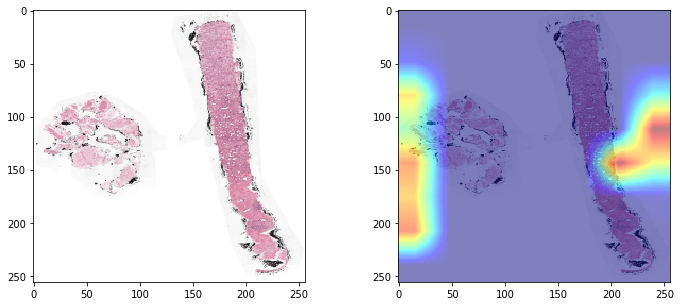

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = se_resnext50_32x4d(num_classes=1000)
model.avg_pool = GeM()
model.last_linear = nn.Linear(in_features=2048, out_features=6, bias=True)
model = model.to(device)
model.load_state_dict(torch.load('../logs/clf_se_resnext50_32x4d_20200426134612_0.673/weight_best.pt'))

img_id = '08134913a9aa1d541f719e9f356f9378'

show_gradcam(model, img_id)